# Using CLIPSeg with Hugging Face Transformers

Using Hugging Face Transformers, you can easily download and run a pre-trained CLIPSeg model on your images. Let’s start by installing transformers.

In [1]:
!pip install -q transformers

To download the model, simply instantiate it.

In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

Now we can load an image to try out the segmentation. We'll choose a picture of a delicious breakfast taken by [Calum Lewis](https://unsplash.com/@calumlewis).

In [ ]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

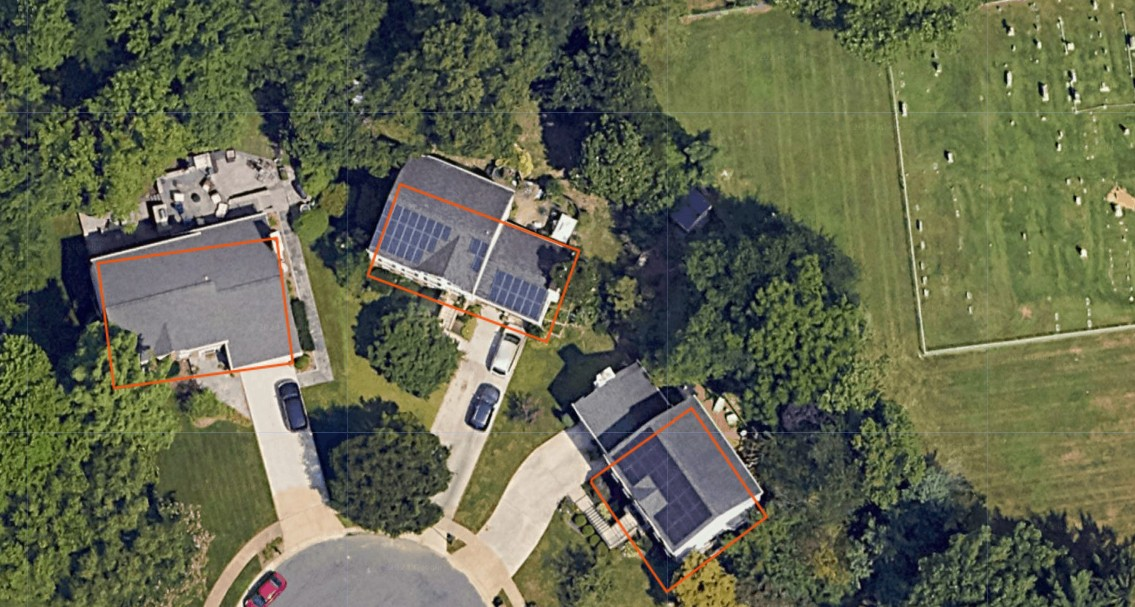

In [55]:
# prompt: /content/testing_sp.jpg ope using PIL

from PIL import Image
image = Image.open("/content/testing_sp.jpg")
image

## Text prompting

Let’s start by defining some text categories we want to segment.

In [40]:
prompts = ["Solar panels installed on roofs with visible photovoltaic cells"]

Now that we have our inputs, we can process them and input them to the model.

In [41]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

Finally, let’s visualize the output.

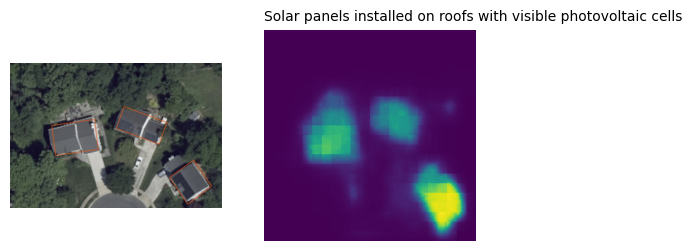

In [42]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

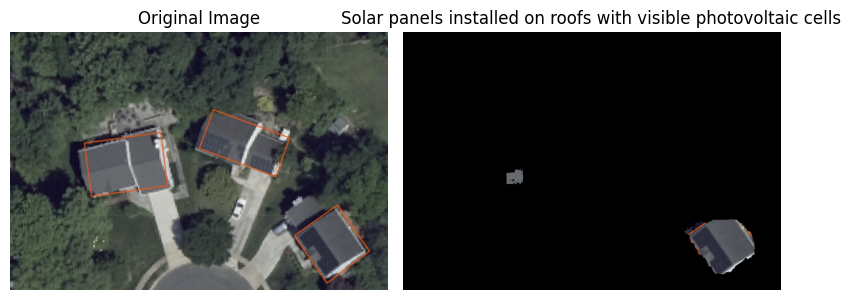

In [43]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Convert PIL image to NumPy array
image = np.array(image)  # Ensure the image is a NumPy array (H, W, 3)

# Apply sigmoid to get probabilities from logits
probabilities = torch.sigmoid(preds).squeeze(1)  # Shape: (num_prompts, H_mask, W_mask)

# Resize masks to match the original image dimensions
segmented_images = []
for i in range(len(prompts)):
    # Convert mask to numpy array
    mask = probabilities[i].detach().cpu().numpy()  # Shape: (H_mask, W_mask)

    # Resize the mask to match the image dimensions (H_image, W_image)
    from skimage.transform import resize
    resized_mask = resize(mask, (image.shape[0], image.shape[1]), mode='constant', anti_aliasing=True)

    # Threshold the resized mask (adjust threshold as needed)
    binary_mask = (resized_mask > 0.5).astype(np.bool_)  # Binary mask (True for segmented regions)

    # Apply the mask to the original image
    segmented_image = np.zeros_like(image)  # Create a blank image with the same shape as the original
    segmented_image[binary_mask] = image[binary_mask]  # Copy segmented regions from the original image
    segmented_images.append(segmented_image)

# Plot the original image and segmented images
fig, ax = plt.subplots(1, len(prompts) + 1, figsize=(4 * (len(prompts) + 1), 6))
[a.axis('off') for a in ax]

# Show the original image in the first subplot
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Show segmented images
for i, prompt in enumerate(prompts):
    ax[i + 1].imshow(segmented_images[i])
    ax[i + 1].set_title(prompt)

plt.tight_layout()
plt.show()


## Visual prompting

As mentioned before, we can also use images as the input prompts (i.e. in place of the category names). This can be especially useful if it's not easy to describe the thing you want to segment. For this example, we'll use a picture of a coffee cup taken by [Daniel Hooper](https://unsplash.com/@dan_fromyesmorecontent).

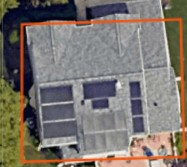

In [47]:
url = "https://unsplash.com/photos/Ki7sAc8gOGE/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTJ8fGNvZmZlJTIwdG8lMjBnb3xlbnwwfHx8fDE2NzExOTgzNDQ&force=true&w=640"
prompt = Image.open("/content/sp_true.jpg")
prompt

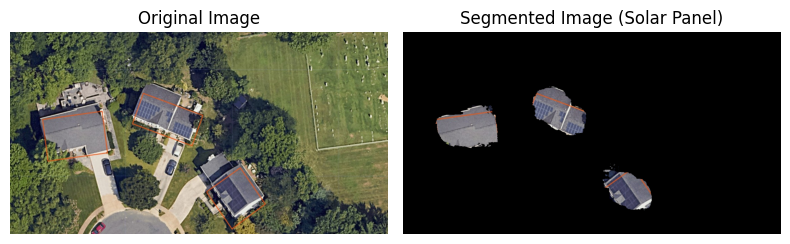

In [45]:
# prompt: /content/sp_true.jpg as visula\ prompt

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Using CLIPSeg with Hugging Face Transformers
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load the image from the local file path
image = Image.open("/content/testing_sp.jpg")

# ## Visual prompting
# Use an image as the visual prompt
prompt_image = Image.open("/content/sp_true.jpg") # Use the same image as the visual prompt

inputs = processor(text=["solar panel"], images=[image], padding="max_length", return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

# Convert PIL image to NumPy array
image = np.array(image)

# Apply sigmoid and resize mask
probabilities = torch.sigmoid(preds).squeeze(1)
segmented_images = []
for i in range(1): # Only one prompt in this case
    mask = probabilities[i].detach().cpu().numpy()
    resized_mask = resize(mask, (image.shape[0], image.shape[1]), mode='constant', anti_aliasing=True)
    binary_mask = (resized_mask > 0.5).astype(np.bool_)
    segmented_image = np.zeros_like(image)
    segmented_image[binary_mask] = image[binary_mask]
    segmented_images.append(segmented_image)


# Plot the original image and segmented image
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
[a.axis('off') for a in ax]
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(segmented_images[0])
ax[1].set_title("Segmented Image (Solar Panel)")
plt.tight_layout()
plt.show()

We can now process the input image and prompt image and input them to the model.

In [48]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

TypeError: Invalid shape (1, 352, 352) for image data

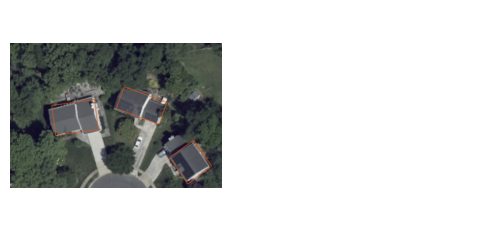

In [51]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

Let’s try one last time by using the visual prompting tips described in the paper, i.e. cropping the image and darkening the background.

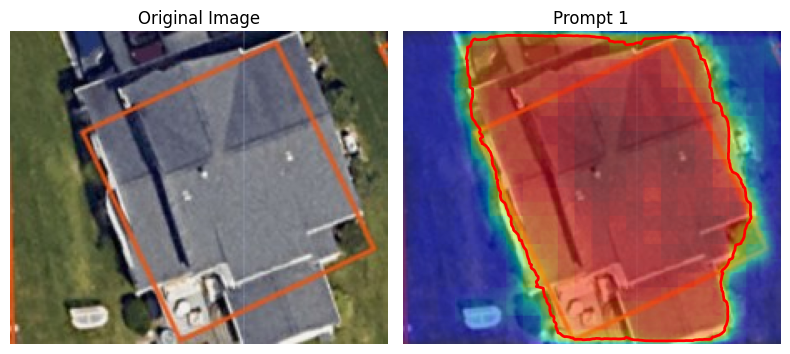

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F

# Assume `image` is the input image (PIL or numpy array)
# Assume `prompt` is the prompt image or text converted to pixel values
# Assume `model` and `processor` are preloaded
image=Image.open("/content/sp_sample1.jpg")
prompt=Image.open("/content/sp_true.jpg")
# Encode the input image and the prompt
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")

# Predict segmentation logits
with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)  # Shape: (1, C, H, W)
preds = torch.transpose(preds, 0, 1)  # Adjust shape to (C, 1, H, W)

# Apply activation (sigmoid for binary segmentation)
probabilities = torch.sigmoid(preds).squeeze(1)  # Shape: (C, H, W)

# Resize predictions to match the original image dimensions
resized_masks = []
for i in range(probabilities.shape[0]):
    mask = probabilities[i]  # Shape: (H, W)
    # Resize the mask using torch.nn.functional.interpolate
    resized_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0),  # Add batch and channel dims
                                  size=(image.size[1], image.size[0]),  # Target size (H, W)
                                  mode="bilinear", align_corners=False).squeeze().cpu().numpy()
    resized_masks.append(resized_mask)

# Plot the original image and segmentation results
fig, ax = plt.subplots(1, len(resized_masks) + 1, figsize=(4 * (len(resized_masks) + 1), 6))

# Show the original image
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title("Original Image")

# Overlay predictions for each prompt
for i, mask in enumerate(resized_masks):
    ax[i + 1].imshow(image)
    ax[i + 1].imshow(mask, alpha=0.5, cmap="jet")  # Overlay mask with transparency
    ax[i + 1].contour(mask, levels=[0.5], colors="red", linewidths=2)  # Add boundary
    ax[i + 1].axis("off")
    ax[i + 1].set_title(f"Prompt {i + 1}")

plt.tight_layout()
plt.show()


In [59]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def calculate_clip_embedding(image, processor, model):
    """
    Calculate CLIP embedding for an image.
    """
    inputs = processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy()

def compare_embeddings(embedding1, embedding2, method='cosine'):
    """
    Compare two embeddings using cosine similarity or euclidean distance.
    """
    if method == 'cosine':
        # Cosine similarity
        similarity = cosine_similarity(embedding1, embedding2)
        return similarity[0][0]
    elif method == 'euclidean':
        # Euclidean distance
        distance = np.linalg.norm(embedding1 - embedding2)
        return distance
    else:
        raise ValueError("Unsupported comparison method. Use 'cosine' or 'euclidean'.")




config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Cosine Similarity: 0.9126
Euclidean Distance: 4.6123


In [63]:
from PIL import Image

def crop_center(image, crop_percentage=0.75):
    """
    Crop the center of the image by the specified percentage.
    """
    width, height = image.size
    crop_width = int(width * crop_percentage)
    crop_height = int(height * crop_percentage)

    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height

    return image.crop((left, top, right, bottom))

# Load images (PIL format)
predicted_image = Image.open("/content/sp_sample2.jpg")
ground_truth_image = Image.open("/content/sp_true.jpg")

# Crop images to 75% of their size (center)
predicted_image_cropped = crop_center(predicted_image, crop_percentage=0.75)
ground_truth_image_cropped = crop_center(ground_truth_image, crop_percentage=0.75)

# Calculate embeddings
predicted_embedding = calculate_clip_embedding(predicted_image_cropped, processor, model)
ground_truth_embedding = calculate_clip_embedding(ground_truth_image_cropped, processor, model)

# Compare embeddings
cosine_sim = compare_embeddings(predicted_embedding, ground_truth_embedding, method='cosine')
euclidean_dist = compare_embeddings(predicted_embedding, ground_truth_embedding, method='euclidean')

# Print results
print(f"Cosine Similarity (cropped): {cosine_sim:.4f}")
print(f"Euclidean Distance (cropped): {euclidean_dist:.4f}")


Cosine Similarity (cropped): 0.8818
Euclidean Distance (cropped): 5.6191


Cosine Similarity (Predicted vs Text): 0.2911
Cosine Similarity (Ground Truth vs Text): 0.2592
Euclidean Distance (Predicted vs Text): 12.2083
Euclidean Distance (Ground Truth vs Text): 13.1701


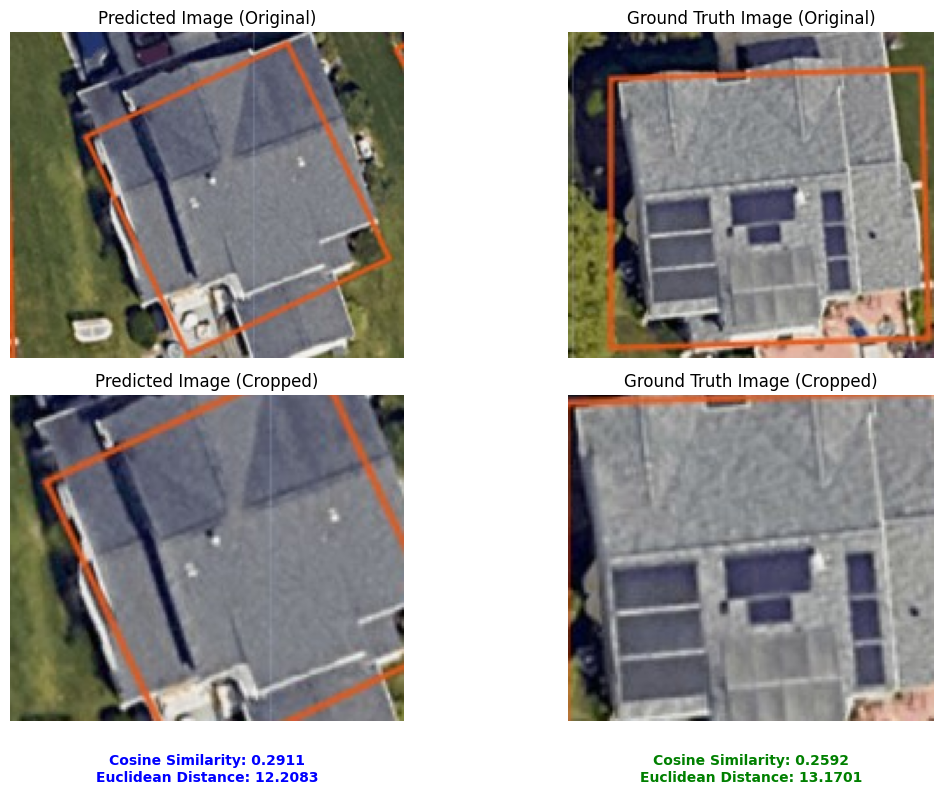

In [77]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def calculate_image_embedding(image, processor, model):
    """
    Calculate CLIP embedding for an image.
    """
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy()

def calculate_text_embedding(text, processor, model):
    """
    Calculate CLIP embedding for a text prompt.
    """
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.cpu().numpy()

def compare_embeddings(embedding1, embedding2, method='cosine'):
    """
    Compare two embeddings using cosine similarity or euclidean distance.
    """
    if method == 'cosine':
        # Cosine similarity
        similarity = cosine_similarity(embedding1, embedding2)
        return similarity[0][0]
    elif method == 'euclidean':
        # Euclidean distance
        distance = np.linalg.norm(embedding1 - embedding2)
        return distance
    else:
        raise ValueError("Unsupported comparison method. Use 'cosine' or 'euclidean'.")

def crop_center(image, crop_percentage=0.75):
    """
    Crop the center of the image by the specified percentage.
    """
    width, height = image.size
    crop_width = int(width * crop_percentage)
    crop_height = int(height * crop_percentage)
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    return image.crop((left, top, right, bottom))

# Load images (PIL format)
predicted_image = Image.open("/content/sp_sample1.jpg")
ground_truth_image = Image.open("/content/sp_true.jpg")

# Crop images to 75% of their size (center)
predicted_image_cropped = crop_center(predicted_image, crop_percentage=0.75)
ground_truth_image_cropped = crop_center(ground_truth_image, crop_percentage=0.75)

# Calculate embeddings for images
predicted_embedding = calculate_image_embedding(predicted_image_cropped, processor, model)
ground_truth_embedding = calculate_image_embedding(ground_truth_image_cropped, processor, model)



Cosine Similarity (Predicted vs Text): 0.2794
Cosine Similarity (Ground Truth vs Text): 0.2371
Euclidean Distance (Predicted vs Text): 11.5037
Euclidean Distance (Ground Truth vs Text): 12.5941


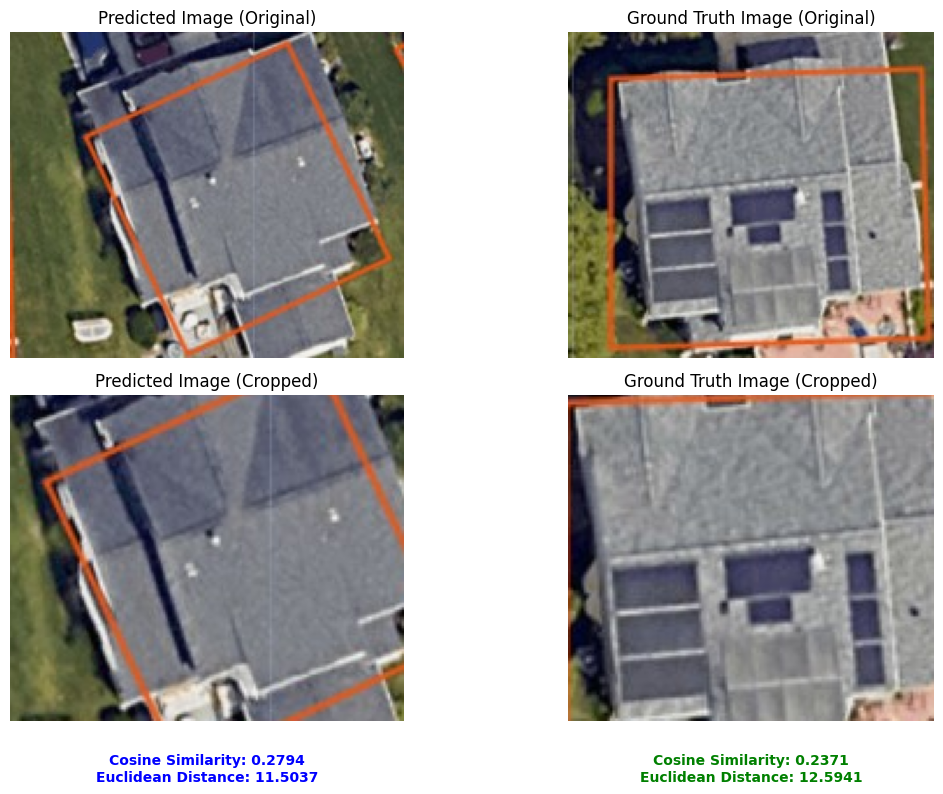

In [81]:

# Calculate text embedding for "solar panel"
text_embedding = calculate_text_embedding("A large residential rooftop with visible solar panels arranged in rows", processor, model)

# Compare image embeddings with text embedding
predicted_cosine_sim = compare_embeddings(predicted_embedding, text_embedding, method='cosine')
ground_truth_cosine_sim = compare_embeddings(ground_truth_embedding, text_embedding, method='cosine')

predicted_euclidean_dist = compare_embeddings(predicted_embedding, text_embedding, method='euclidean')
ground_truth_euclidean_dist = compare_embeddings(ground_truth_embedding, text_embedding, method='euclidean')

# Print results
print(f"Cosine Similarity (Predicted vs Text): {predicted_cosine_sim:.4f}")
print(f"Cosine Similarity (Ground Truth vs Text): {ground_truth_cosine_sim:.4f}")
print(f"Euclidean Distance (Predicted vs Text): {predicted_euclidean_dist:.4f}")
print(f"Euclidean Distance (Ground Truth vs Text): {ground_truth_euclidean_dist:.4f}")

# Visualization: Original and Cropped Images
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Show original images
ax[0, 0].imshow(predicted_image)
ax[0, 0].axis("off")
ax[0, 0].set_title("Predicted Image (Original)")

ax[0, 1].imshow(ground_truth_image)
ax[0, 1].axis("off")
ax[0, 1].set_title("Ground Truth Image (Original)")

# Show cropped images with similarity and distance scores
ax[1, 0].imshow(predicted_image_cropped)
ax[1, 0].axis("off")
ax[1, 0].set_title("Predicted Image (Cropped)")
ax[1, 0].text(
    0.5, -0.1,
    f"Cosine Similarity: {predicted_cosine_sim:.4f}\nEuclidean Distance: {predicted_euclidean_dist:.4f}",
    fontsize=10, color="blue", ha="center", va="top", transform=ax[1, 0].transAxes, weight="bold"
)

ax[1, 1].imshow(ground_truth_image_cropped)
ax[1, 1].axis("off")
ax[1, 1].set_title("Ground Truth Image (Cropped)")
ax[1, 1].text(
    0.5, -0.1,
    f"Cosine Similarity: {ground_truth_cosine_sim:.4f}\nEuclidean Distance: {ground_truth_euclidean_dist:.4f}",
    fontsize=10, color="green", ha="center", va="top", transform=ax[1, 1].transAxes, weight="bold"
)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


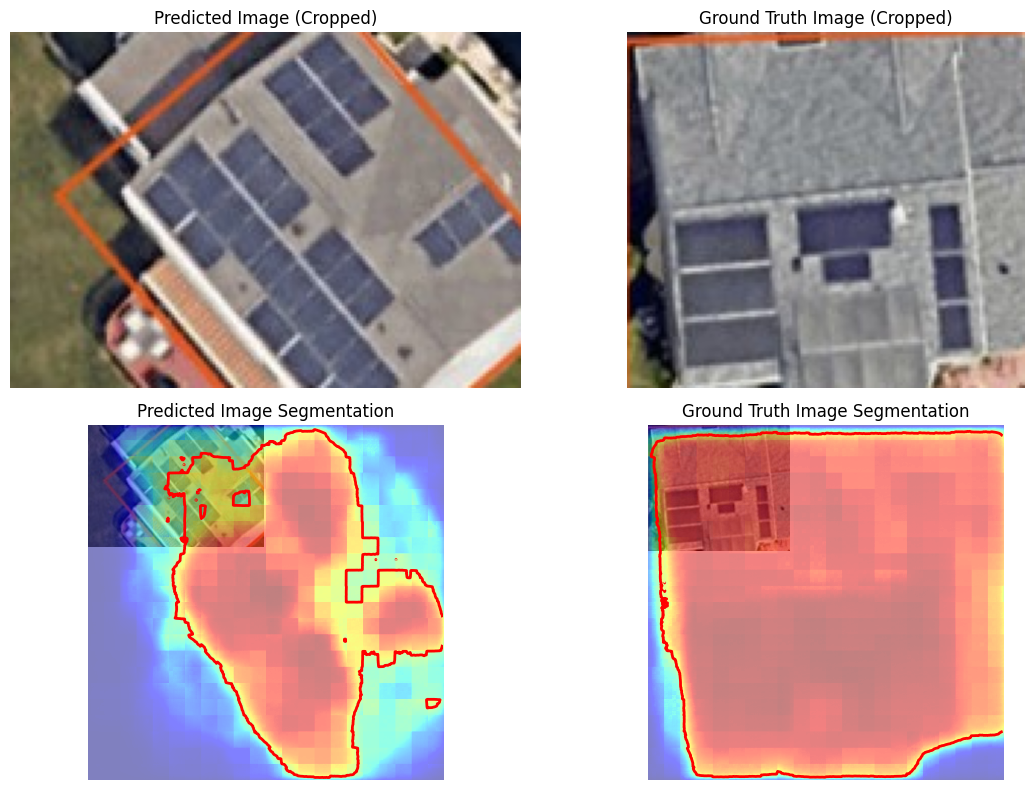

In [72]:
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Load CLIPSeg model and processor
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

def crop_center(image, crop_percentage=0.75):
    """
    Crop the center of the image by the specified percentage.
    """
    width, height = image.size
    crop_width = int(width * crop_percentage)
    crop_height = int(height * crop_percentage)
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    return image.crop((left, top, right, bottom))

# Load images (PIL format)
predicted_image = Image.open("/content/sp_sample3.jpg")
ground_truth_image = Image.open("/content/sp_true.jpg")

# Crop images
predicted_image_cropped = crop_center(predicted_image, crop_percentage=0.75)
ground_truth_image_cropped = crop_center(ground_truth_image, crop_percentage=0.75)

# Prompt for segmentation
prompt = "solar panel"

# Process the cropped images with CLIPSeg
def apply_clipseg(image, prompt, processor, model):
    inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    mask = torch.sigmoid(outputs.logits)  # Apply sigmoid to get probabilities
    return mask.squeeze(0).cpu().numpy()

predicted_mask = apply_clipseg(predicted_image_cropped, prompt, processor, model)
ground_truth_mask = apply_clipseg(ground_truth_image_cropped, prompt, processor, model)

# Plot original cropped images and segmentation results
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Predicted Image and Segmentation
ax[0, 0].imshow(predicted_image_cropped)
ax[0, 0].axis("off")
ax[0, 0].set_title("Predicted Image (Cropped)")

ax[1, 0].imshow(predicted_image_cropped)
ax[1, 0].imshow(predicted_mask, alpha=0.5, cmap="jet")  # Overlay segmentation mask
ax[1, 0].contour(predicted_mask, levels=[0.5], colors="red", linewidths=2)  # Add segmentation boundary
ax[1, 0].axis("off")
ax[1, 0].set_title("Predicted Image Segmentation")

# Ground Truth Image and Segmentation
ax[0, 1].imshow(ground_truth_image_cropped)
ax[0, 1].axis("off")
ax[0, 1].set_title("Ground Truth Image (Cropped)")

ax[1, 1].imshow(ground_truth_image_cropped)
ax[1, 1].imshow(ground_truth_mask, alpha=0.5, cmap="jet")  # Overlay segmentation mask
ax[1, 1].contour(ground_truth_mask, levels=[0.5], colors="red", linewidths=2)  # Add segmentation boundary
ax[1, 1].axis("off")
ax[1, 1].set_title("Ground Truth Image Segmentation")

plt.tight_layout()
plt.show()


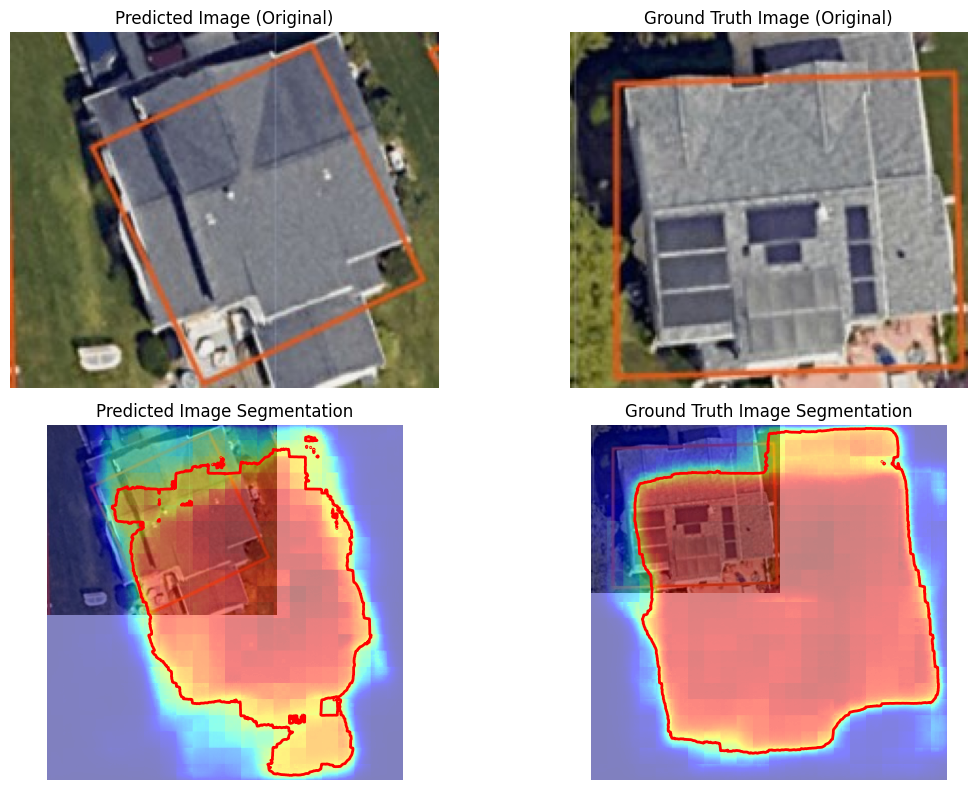

In [74]:
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import matplotlib.pyplot as plt

# Load CLIPSeg model and processor
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load images (PIL format)
predicted_image = Image.open("/content/sp_sample1.jpg")
ground_truth_image = Image.open("/content/sp_true.jpg")

# Prompt for segmentation
prompt = "solar panel"

# Process the original images with CLIPSeg
def apply_clipseg(image, prompt, processor, model):
    inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    mask = torch.sigmoid(outputs.logits)  # Apply sigmoid to get probabilities
    return mask.squeeze(0).cpu().numpy()

predicted_mask = apply_clipseg(predicted_image, prompt, processor, model)
ground_truth_mask = apply_clipseg(ground_truth_image, prompt, processor, model)

# Plot original images and segmentation results
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Predicted Image and Segmentation
ax[0, 0].imshow(predicted_image)
ax[0, 0].axis("off")
ax[0, 0].set_title("Predicted Image (Original)")

ax[1, 0].imshow(predicted_image)
ax[1, 0].imshow(predicted_mask, alpha=0.5, cmap="jet")  # Overlay segmentation mask
ax[1, 0].contour(predicted_mask, levels=[0.5], colors="red", linewidths=2)  # Add segmentation boundary
ax[1, 0].axis("off")
ax[1, 0].set_title("Predicted Image Segmentation")

# Ground Truth Image and Segmentation
ax[0, 1].imshow(ground_truth_image)
ax[0, 1].axis("off")
ax[0, 1].set_title("Ground Truth Image (Original)")

ax[1, 1].imshow(ground_truth_image)
ax[1, 1].imshow(ground_truth_mask, alpha=0.5, cmap="jet")  # Overlay segmentation mask
ax[1, 1].contour(ground_truth_mask, levels=[0.5], colors="red", linewidths=2)  # Add segmentation boundary
ax[1, 1].axis("off")
ax[1, 1].set_title("Ground Truth Image Segmentation")

plt.tight_layout()
plt.show()


In [ ]:
url = "https://i.imgur.com/mRSORqz.jpg"
alternative_prompt = Image.open(requests.get(url, stream=True).raw)
alternative_prompt


In [ ]:
encoded_alternative_prompt = processor(images=[alternative_prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_alternative_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

In this case, the result is pretty much the same. This is probably because the coffee cup was already separated well from the background in the original image.

# Using CLIPSeg to pre-label images on Segments.ai

As you can see, the results from CLIPSeg are a little fuzzy and very low-res. If we want to obtain better results, you can fine-tune a state-of-the-art segmentation model, as explained in [our previous blogpost](https://huggingface.co/blog/fine-tune-segformer). To finetune the model, we'll need labeled data. In this section, we'll show you how you can use CLIPSeg to create some rough segmentation masks and then refine them on [Segments.ai](https://segments.ai/?utm_source=hf&utm_medium=colab&utm_campaign=clipseg), the best labeling platform for image segmentation.  

First, create an account at [https://segments.ai/join](https://segments.ai/join?utm_source=hf&utm_medium=colab&utm_campaign=clipseg) and install the Segments Python SDK. Then you can initialize the Segments.ai Python client using an API key. This key can be found on [the account page](https://segments.ai/account).

In [ ]:
!pip install -q segments-ai

In [ ]:
from segments import SegmentsClient
from getpass import getpass

api_key = getpass('Enter your API key: ')
segments_client = SegmentsClient(api_key)

Next, let's load an image from a dataset using the Segments client. We'll use the [a2d2 self-driving dataset](https://www.a2d2.audi/a2d2/en.html). You can also create your own dataset by following [these instructions](https://docs.segments.ai/tutorials/getting-started).

In [ ]:
samples = segments_client.get_samples("admin-tobias/clipseg")

# Use the last image as an example
sample = samples[1]
image = Image.open(requests.get(sample.attributes.image.url, stream=True).raw)
image

We also need to get the category names from the dataset attributes.

In [ ]:
dataset = segments_client.get_dataset("admin-tobias/clipseg")
category_names = [category.name for category in dataset.task_attributes.categories]

Now we can use CLIPSeg on the image as before. This time, we'll also scale up the outputs so that they match the input image's size.

In [ ]:
from torch import nn

inputs = processor(text=category_names, images=[image] * len(category_names), padding="max_length", return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**inputs)

# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

And we can visualize the results again.

In [ ]:
len_cats = len(category_names)
_, ax = plt.subplots(1, len_cats + 1, figsize=(3*(len_cats + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len_cats)];
[ax[i+1].text(0, -15, category_name) for i, category_name in enumerate(category_names)];

Now we have to combine the predictions to a single segmentated image. We'll simply do this by taking the category with the greatest sigmoid value for each patch. We'll also make sure that all the values under a certain threshold do not count.

In [ ]:
threshold = 0.1

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

Let's quickly visualize the result.

In [ ]:
plt.imshow(inds)

Lastly, we can upload the prediction to Segments.ai. To do that, we'll first convert the bitmap to a png file, then we'll upload this file to the Segments, and finally we'll add the label to the sample.

In [ ]:
from segments.utils import bitmap2file
import numpy as np

inds_np = inds.numpy().astype(np.uint32)
unique_inds = np.unique(inds_np).tolist()
f = bitmap2file(inds_np, is_segmentation_bitmap=True)

asset = segments_client.upload_asset(f, "clipseg_prediction.png")

attributes = {
      'format_version': '0.1',
      'annotations': [{"id": i, "category_id": i} for i in unique_inds if i != 0],
      'segmentation_bitmap': { 'url': asset.url },
  }

segments_client.add_label(sample.uuid, 'ground-truth', attributes)

If you take a look at the [uploaded prediction on Segments.ai](https://segments.ai/admin-tobias/clipseg/samples/71a80d39-8cf3-4768-a097-e81e0b677517/ground-truth), you can see that it's not perfect. However, you can manually correct the biggest mistakes, and then you can use the corrected dataset to train a better model than CLIPSeg.